##Consumer Finance Complaints Classification using LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import preprocessing
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Lstm/consumer_complaints.csv')
df.info

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<bound method DataFrame.info of        date_received           product  ... consumer_disputed? complaint_id
0         08/30/2013          Mortgage  ...                Yes       511074
1         08/30/2013          Mortgage  ...                Yes       511080
2         08/30/2013  Credit reporting  ...                 No       510473
3         08/30/2013      Student loan  ...                Yes       510326
4         08/30/2013   Debt collection  ...                Yes       511067
...              ...               ...  ...                ...          ...
555952    07/01/2014          Mortgage  ...                 No       919529
555953    07/01/2014          Mortgage  ...                 No       918447
555954    07/10/2012          Mortgage  ...                 No       114550
555955    04/14/2015   Debt collection  ...                 No      1329963
555956    08/14/2014   Debt collection  ...                 No       984116

[555957 rows x 18 columns]>

In [ ]:
df['consumer_complaint_narrative'].value_counts()

This company continues to report on my credit report after I sent them a letter telling them that this account was not mine and I have no idea what it is or who it belongs to! \n\nI asked for proof of a signed contract, I asked for a license to collect in my state, I asked for copies of all information referenced for this debt and still to date, I have not received anything but harassment from this company! \n\nTHIS IS NOT MY DEBT! \n\nI WANT THIS ACCOUNT REMOVED FROM MY CREDIT REPORT AND THIS COMPANY TO STOP CONTACTING ME IMMEDIATELY! \n                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
df['product'].value_counts()

Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: product, dtype: int64

In [ ]:
complains = df[["product","consumer_complaint_narrative"]]
complains["consumer_complaint_narrative"].isnull().value_counts()
complains["product"].value_counts()

Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: product, dtype: int64

In [ ]:
df_complains = complains.dropna().reset_index().drop("index",axis =1)
df_complains["product"].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

In [ ]:
def print_plot(index):
    print(df_complains["consumer_complaint_narrative"].iloc[index])
    print("Product: ",df_complains["product"].iloc[index])
    print("\n")
print_plot(12)
print_plot(15)

I have a car loan with PNC bank. In XXXX of 2014 I sent a payment of {$250.00} in the form of a money order. PNC bank lost my payment. After that mishap I began to submit. my payments online, via bill payment. Now this month I submitted a payment of {$300.00}, online as before, they will not release the money to my account. I have proof that I sent the payment and PNC bank still refuses to accept the payment. 

Product:  Consumer Loan


In XX/XX/XXXX I filed a police report regarding my wallet being stolen which had money, credit cards, driver 's license, SS card, and checks. I immediately went to my bank and closed the account and reopened a new one and received new checks with a different account number. The person who stole my wallet had used my debit card ... but since it was still pending ... the bank was able to block the withdrawal. I placed a fraud alert on my credit reports and I got a new driver 's license and then ended up getting a XXXX one with my new name since I had marr

##PRE PROCESSING

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
def clean_text(text):
    text = text.lower()
    pattern = re.compile(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]")
    text = re.sub(pattern,"",text)
    text = text.replace("x","")
    text = text.split()
    texts = [word for word in text if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    cleaned_text = [word for word in texts if word not in stop_words]
    cleaned_text = " ".join(cleaned_text)
    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_complains["consumer_complaint_narrative"] = df_complains["consumer_complaint_narrative"].apply(clean_text)
print_plot(15)

filed police report regarding wallet stolen money credit cards driver license ss card checks immediately went bank closed account reopened new one received new checks different account number person stole wallet used debit card since still pending bank able block withdrawal placed fraud alert credit reports got new driver license ended getting one new name since married last week received letter meade associates attempting collect debt checks written old account old drivers license name starting called spoke agreed everything done correctly needed send information bank police report along current drivers license requested send copies checks written went bank anything specific since nothing actually went account time however new closed account reopened new one presented police report wrote letter give able retrieve police report online monday faed documents along current drivers license actual signature well new police report number case filed forgeryfraud department followed call tuesd

In [ ]:
print_plot(19)

trying deal navient formerly regarding private loans taken college tuition name mother primary borrower cosigner admitted phone repeatedly giving money phone eact amount want eorbitant document phone call started dealing via paper letters taken kindly loans primary borrower epecting well month payments unreasonable income given multiple financial statements phone apparently putting system net time talk someone say nothing file give statements agree month much nothing else available ask recommend say even bother sending amount actually afford without losing home car needed job enough anything worthwhile make fun going career path hoping college demand know loans mother primary borrower one lower payment plan confirmation numbers payments taking checking account received letter mail stating payment plan rejected reason trying find writing yet even date letter sent money still taken account navient also still receiving letters phone calls particular account delinquent even though making p

In [ ]:
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.preprocessing.text import Tokenizer

# maximum number of words in our vocabulary
max_nb_words = 50000
# maximum number of words within each complaint document 
max_sequence_length = 250

embedding_dim = 100

tokenizer= Tokenizer(num_words = max_nb_words,
                    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                    lower = True,
                    split = " ",
                    char_level = False)

In [ ]:
tokenizer.fit_on_texts(df_complains["consumer_complaint_narrative"].to_numpy())
word_index = tokenizer.word_index
print("Found unique tokens", len(word_index))

Found unique tokens 60270


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df_complains["consumer_complaint_narrative"].to_numpy())
X = pad_sequences(X,maxlen = max_sequence_length)
print("shape of data tensor:", X.shape)

shape of data tensor: (66806, 250)


In [ ]:
print(X[1])
print(tokenizer.sequences_to_texts([X[1]]))

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0    33  5008    35
   187     7     6    35   116     1    51   241   198   953   251    24
   205    74    99    68   276  1521   113     1   

In [ ]:
df_complains["product"].values

array(['Debt collection', 'Consumer Loan', 'Mortgage', ..., 'Payday loan',
       'Mortgage', 'Mortgage'], dtype=object)

##Training the model

In [ ]:
y = pd.get_dummies(df_complains["product"]).values
print("Shape of target tensor", y.shape)

Shape of target tensor (66806, 11)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size = 0.1,
                                                random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(60125, 250) (60125, 11)
(6681, 250) (6681, 11)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(max_nb_words,embedding_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(11,activation = "softmax"))
model.compile(loss = "categorical_crossentropy",optimizer = "adam", metrics = ["accuracy"])

EPOCHS = 5
batch_size = 64



In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
846/846 [==============================] - 614s 723ms/step - loss: 1.4305 - accuracy: 0.5206 - val_loss: 0.8387 - val_accuracy: 0.7615
Epoch 2/5
846/846 [==============================] - 675s 798ms/step - loss: 0.7757 - accuracy: 0.7779 - val_loss: 0.7278 - val_accuracy: 0.7840
Epoch 3/5
846/846 [==============================] - 609s 720ms/step - loss: 0.6336 - accuracy: 0.8158 - val_loss: 0.6172 - val_accuracy: 0.8231
Epoch 4/5
846/846 [==============================] - 612s 724ms/step - loss: 0.4891 - accuracy: 0.8596 - val_loss: 0.5564 - val_accuracy: 0.8423
Epoch 5/5
846/846 [==============================] - 603s 713ms/step - loss: 0.4112 - accuracy: 0.8797 - val_loss: 0.5679 - val_accuracy: 0.8359


##Accuracy and Loss

In [ ]:
accr = model.evaluate(X_test,y_test)
print("Test set \n Loss: {} \n Accuracy: {}".format(accr[0],accr[1]))

209/209 [==============================] - 13s 62ms/step - loss: 0.6011 - accuracy: 0.8231
Test set 
 Loss: 0.6011276245117188 
 Accuracy: 0.8230803608894348


In [ ]:
history.history


{'accuracy': [0.6412255764007568,
  0.7827838659286499,
  0.8207606673240662,
  0.8610289692878723,
  0.8804147243499756],
 'loss': [1.1399083137512207,
  0.7507742047309875,
  0.618269681930542,
  0.4813796281814575,
  0.40993672609329224],
 'val_accuracy': [0.7615166902542114,
  0.7839680910110474,
  0.8230500817298889,
  0.8423416018486023,
  0.8358556628227234],
 'val_loss': [0.8386667966842651,
  0.7277626395225525,
  0.6172273755073547,
  0.5564112067222595,
  0.5679055452346802]}

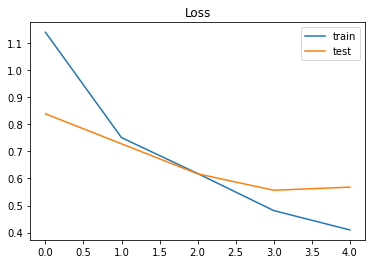

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

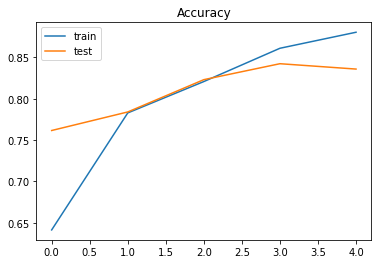

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

##predictions

In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_sequence_length)
pred = model1.predict(padded)
Labels = ['Other financial service','Money transfers','Payday loan','Debt collection','Mortgage','Credit reporting','Credit card','Bank account or service','Consumer Loan','Student loan','Prepaid card']print(pred, labels[np.argmax(pred)])

In [ ]:
new_complaint = ['I was charged {$140.00} in Overdraft fees for {$20.00} overdraft as well as on XXXX/XXXX & XX/XX/XXXX I was charged 2 Overdraft fees over the same transaction twice']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_sequence_length)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[9.8914868e-01 9.7613782e-04 2.1621101e-03 8.6279761e-05 6.6304638e-04
  4.1764267e-03 1.3492173e-03 5.5299280e-04 3.9650782e-04 2.4284312e-04
  2.4586037e-04]] Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
new_complaint = ['My ID was stolen 2012. Used for medical stuff I do not know or recognize. I have disputed to all XXXX credit bureaus, but it has not been taken off my credit report yet. Please help!']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_sequence_length)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports',  'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.7743546e-03 5.0941110e-03 3.2664694e-02 6.1646861e-01 3.4000298e-01
  1.0691974e-04 2.1407823e-03 3.2123941e-04 4.2167772e-04 2.9990103e-04
  7.0479838e-04]] Bank account or service


In [ ]:
new_complaint = ['I attended a presentation in XXXX, and the company ran my credit card for almost {$31000.00}. I did not authorize the charges. I revisited the merchant after seeing the charge, they provided me a letter stating they would refund my monies. this never occured. I called Citibank my card issuer, opened a fraud dispute at the customer service reps advice, heard nothing until XX/XX/XXXX where the case was closed as they stated this was not fraud it was billing dispute. I did speak with the investigator, she asked me to send in a notarized copy of the situation and then I opened the billing dispute. Weekly I have been contacting Citibank with no resolution, and this week they told me that too much time has elapsed and they could not assist me. there was not any moment I waited longer than 48 hours to return any documentation they asked for, and the initial charge back was open within 10 days of the charge. Since XX/XX/XXXX the merchant has disconnected their phones and removed website. I have asked the issue for arbitration, and they have told me I can not request arbitration on this issue as they need to open arbitration with the acquiring bank.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_sequence_length)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[6.6176638e-02 4.6089943e-03 9.1155803e-01 1.6534692e-03 1.2334696e-02
  4.9252069e-04 3.9496648e-04 2.5353627e-04 2.4887771e-04 2.2381477e-03
  4.0111398e-05]] Credit card or prepaid card


In [ ]:
new_complaint = ['XXXX XXXX I purchased ( paid cash ) a home from H.U.D. I use t " The mortgage servicer intends to protect this property from waste and/or deterioration ''. Please keep in mind I paid cash for this property and there was no mortgage!!  of the door, they also left a bigger note on the inside window to be viable from the outside regarding whom to contact ( XXXX ) in case of vandalism or city ordinance violations..This note also clearly stated " XXXX DOES NOT HAVE SALE/RENTAL INFORMATION '' I called the number provided on this poster and they asked for the address and my mortgage companies name..When I advised I did not have a mortgagee on this property I paid cash to HUD they would not give me any info as to whom authorized the break in to secure it. I even threatened to call the police to no avail. It was as if they were protecting their client from being identified. They would not give me the name of the mortgage company allowing me to make contact. I had to research the county records to find out whom the previous mortgage holder was. I found FlagStar Bank had held the previous mortgage so I called XXXX and when they asked whom my mortgagor was I told them Flagstar bank, they then confirmed that it was Flagstar Bank that I need to make pay or make arrangements with. I contacted the assistant to the President of Flagstar and was told I would need to file a request on XXXX of their forms and they would get back to me. I then informed him no way in heck was I going to file a claim on XXXX of their stupid forms and they better darn well pay for my damages that they had caused to be done or I \'d file suit against them. To make this short he did agree to check it out and they did finally admit their wrong doing but would n\'t offer what I thought was a fair offer regarding my damages. I have started a legal suit against them. My concern is how many times have they already done this and/or how many more times will they repeat it? You folks ( Consumer Financial Protection Bureau ) fined this same bank XXXX XXXX dollars for their improper mortgage practices in XXXX of XXXX. File No XXXX. Yet they seem not to care, The excuse I was given we are in the process of changes some of our policies and this must have slipped through the cracks. This is suppose to be a Financial Institution that follows the legal banking rules and regulations? Attempting to repossess a property XXXX for the same loan that they had already gone through the process of returning it for the government loan guarantee and HUD had already resold. I ca n\'t believe they could be so incompetent, especially after being fined ( evidently a small enough amount that it did make a difference to them ) XXXX XXXX dollars for what I would call similar practices regarding handling mortgages!']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_sequence_length)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[8.3679089e-04 1.2480801e-03 1.7381930e-04 7.0131134e-04 3.9987094e-03
  2.5601306e-05 9.9260145e-01 9.4092757e-05 5.6971603e-05 3.7925342e-06
  2.5942901e-04]] Checking or savings account


In [ ]:
model.save("/content/drive/MyDrive/Lstm/my_model")

INFO:tensorflow:Assets written to: /content/my_model/assets


##Running Trained model on UI


In [ ]:
!pip install streamlit

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-04-28 10:58:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.205.198.58, 34.232.92.41, 54.235.211.105, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.205.198.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13828408 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  13.19M  28.5MB/s    in 0.5s    

2021-04-28 10:58:56 (28.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [13828408/13828408]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: http://64a811b3eb25.ngrok.io


In [ ]:
!streamlit run /content/drive/MyDrive/Lstm/tdl.py

2021-04-28 11:00:07.092668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.245.133.188:8501

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2021-04-28 11:00:14.920334: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-28 11:00:14.921466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-28 11:00:14.933636: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-28 11:00:14.933691: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6133928bd9a8